In [93]:
# data processing 

# fetching the values from s3
# getting the fsc curves and resolutions

import os, boto3, sys, smart_open

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import interpolate 
from scipy import optimize
from tqdm import tqdm

In [158]:
# read the fsc curve
def fetch_fsc(s3uri): 
    
    qs, fscs = [], []
    for line in smart_open.open(s3uri):
        line.strip()
        q, fsc = line.split()
        qs.append(float(q))
        fscs.append(float(fsc))
        
    return np.array([qs, fscs]).transpose()
    

def resolution(fsc, thres=0.143): 
    spl = interpolate.interp1d(fsc[:, 0], fsc[:, 1])
    def f(x): return spl(x) - thres
    # print(fsc[10, 0], fsc[-10, 0])
    u = optimize.root_scalar(f, x0=fsc[10, 0], x1=fsc[-10, 0])
    # u = optimize.root_scalar(f, x0=0.1, x1=0.3)
    assert u.converged
    
    return 1 / u.root

In [106]:
# experimental
rlt1 = dict()

for particle in ['5k', '30k', '50k']:
    print(particle)
    s3uri = f's3://seismictx-cryoem/diffem/data/denoised/test-{particle}/vanilla/refinement/{particle}/postprocess_fsc.dat'
    if particle == '5k': s3uri = f's3://seismictx-cryoem/diffem/data/denoised/test-{particle}/vanilla/refinement/{particle}-test/postprocess_fsc.dat'
    fsc = fetch_fsc(s3uri)
    res = resolution(fsc)
    rlt1[particle] = dict()
    rlt1[particle]['fsc'] = fsc
    rlt1[particle]['res'] = res
    print(particle, res)


5k
5k 6.264240876329259
30k
30k 3.8413730946170745
50k
50k 3.7230534295496294


In [160]:
rlt2 = dict()
model_names = ['DiffEM_1000_1000_2022-12-14-19-39-03', 'DiffEM_2023-02-06-21-50-46']
for model_name in model_names: 
    d = dict()
    
    for particle in tqdm(['5k', '30k', '50k']):
        d[particle] = dict()
    
        for nl in [50, 99, 249, 499]: 
            d[particle][f'nl_{nl}'] = dict()

            for hall in [0.0, 0.1, 0.2, 0.5, 1.0]: 
                d[particle][f'nl_{nl}'][f'halluc_{hall:.1f}'] = dict()

                uri = f's3://seismictx-cryoem/diffem/data/denoised/test-{particle}/{model_name}/refinement/denoised_samples_nl_{nl}_halluc_{hall:.1f}_50_steps/postprocess_fsc.dat'
                try: fsc = fetch_fsc(uri)
                except KeyboardInterrupt: raise
                except: fsc = None
                
                try: res = resolution(fsc)
                except KeyboardInterrupt: raise
                except: res = None
                
                d[particle][f'nl_{nl}'][f'halluc_{hall:.1f}']['fsc'] = fsc
                d[particle][f'nl_{nl}'][f'halluc_{hall:.1f}']['res'] = res
                
    
    rlt2[model_name] = d

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


In [161]:
model_name = 'DiffEM_2023-02-06-21-50-46'
particle = '5k'

for k, v in rlt2[model_name][particle].items():
    print(f'-- {k} --')
    for h in v.keys():
        print(h, v[h]['res'])

-- nl_50 --
halluc_0.0 4.325824527218423
halluc_0.1 4.371636815166827
halluc_0.2 4.345999182328294
halluc_0.5 4.334450679336715
halluc_1.0 4.385389523484718
-- nl_99 --
halluc_0.0 None
halluc_0.1 None
halluc_0.2 None
halluc_0.5 None
halluc_1.0 None
-- nl_249 --
halluc_0.0 6.3393429497209
halluc_0.1 6.673915533597472
halluc_0.2 6.246762338238026
halluc_0.5 6.75923896659896
halluc_1.0 None
-- nl_499 --
halluc_0.0 6.130194876404972
halluc_0.1 5.239192883258999
halluc_0.2 6.169159345299427
halluc_0.5 None
halluc_1.0 None


In [163]:
## plot fscs for comparisons
def plot_fscs(fsc, dct, model_name='model', particle='5k'): 
    
    # for the noise level
    line_styles = ['solid', 'dotted', 'dashed', 'dashdot']
    
    # for the hallucinations
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
    
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=600)
    ax.plot(fsc[:, 0], fsc[:, 1], color='black', lw=5, label='Un-denoised')
    
    for i, (nl, v) in enumerate(dct.items()): 
        
        for j, (hall, data) in enumerate(v.items()):
            
            if data['fsc'] is None: continue
            res = data['res']
            if res is None: res = -0.1
            ax.plot(data['fsc'][:, 0], data['fsc'][:, 1], color=colors[j], linestyle=line_styles[i], alpha=0.7, lw=3, label=f'{nl}_{hall} Res = {res:.3f}')
    
    ax.set_xlabel('Resolution (1/A)')
    ax.set_ylabel('Fourier Shell Correlation')
    ax.set_title(f'Dissufion: {model_name}, {particle} particles')
    plt.legend()
    plt.grid()
    plt.show()
            

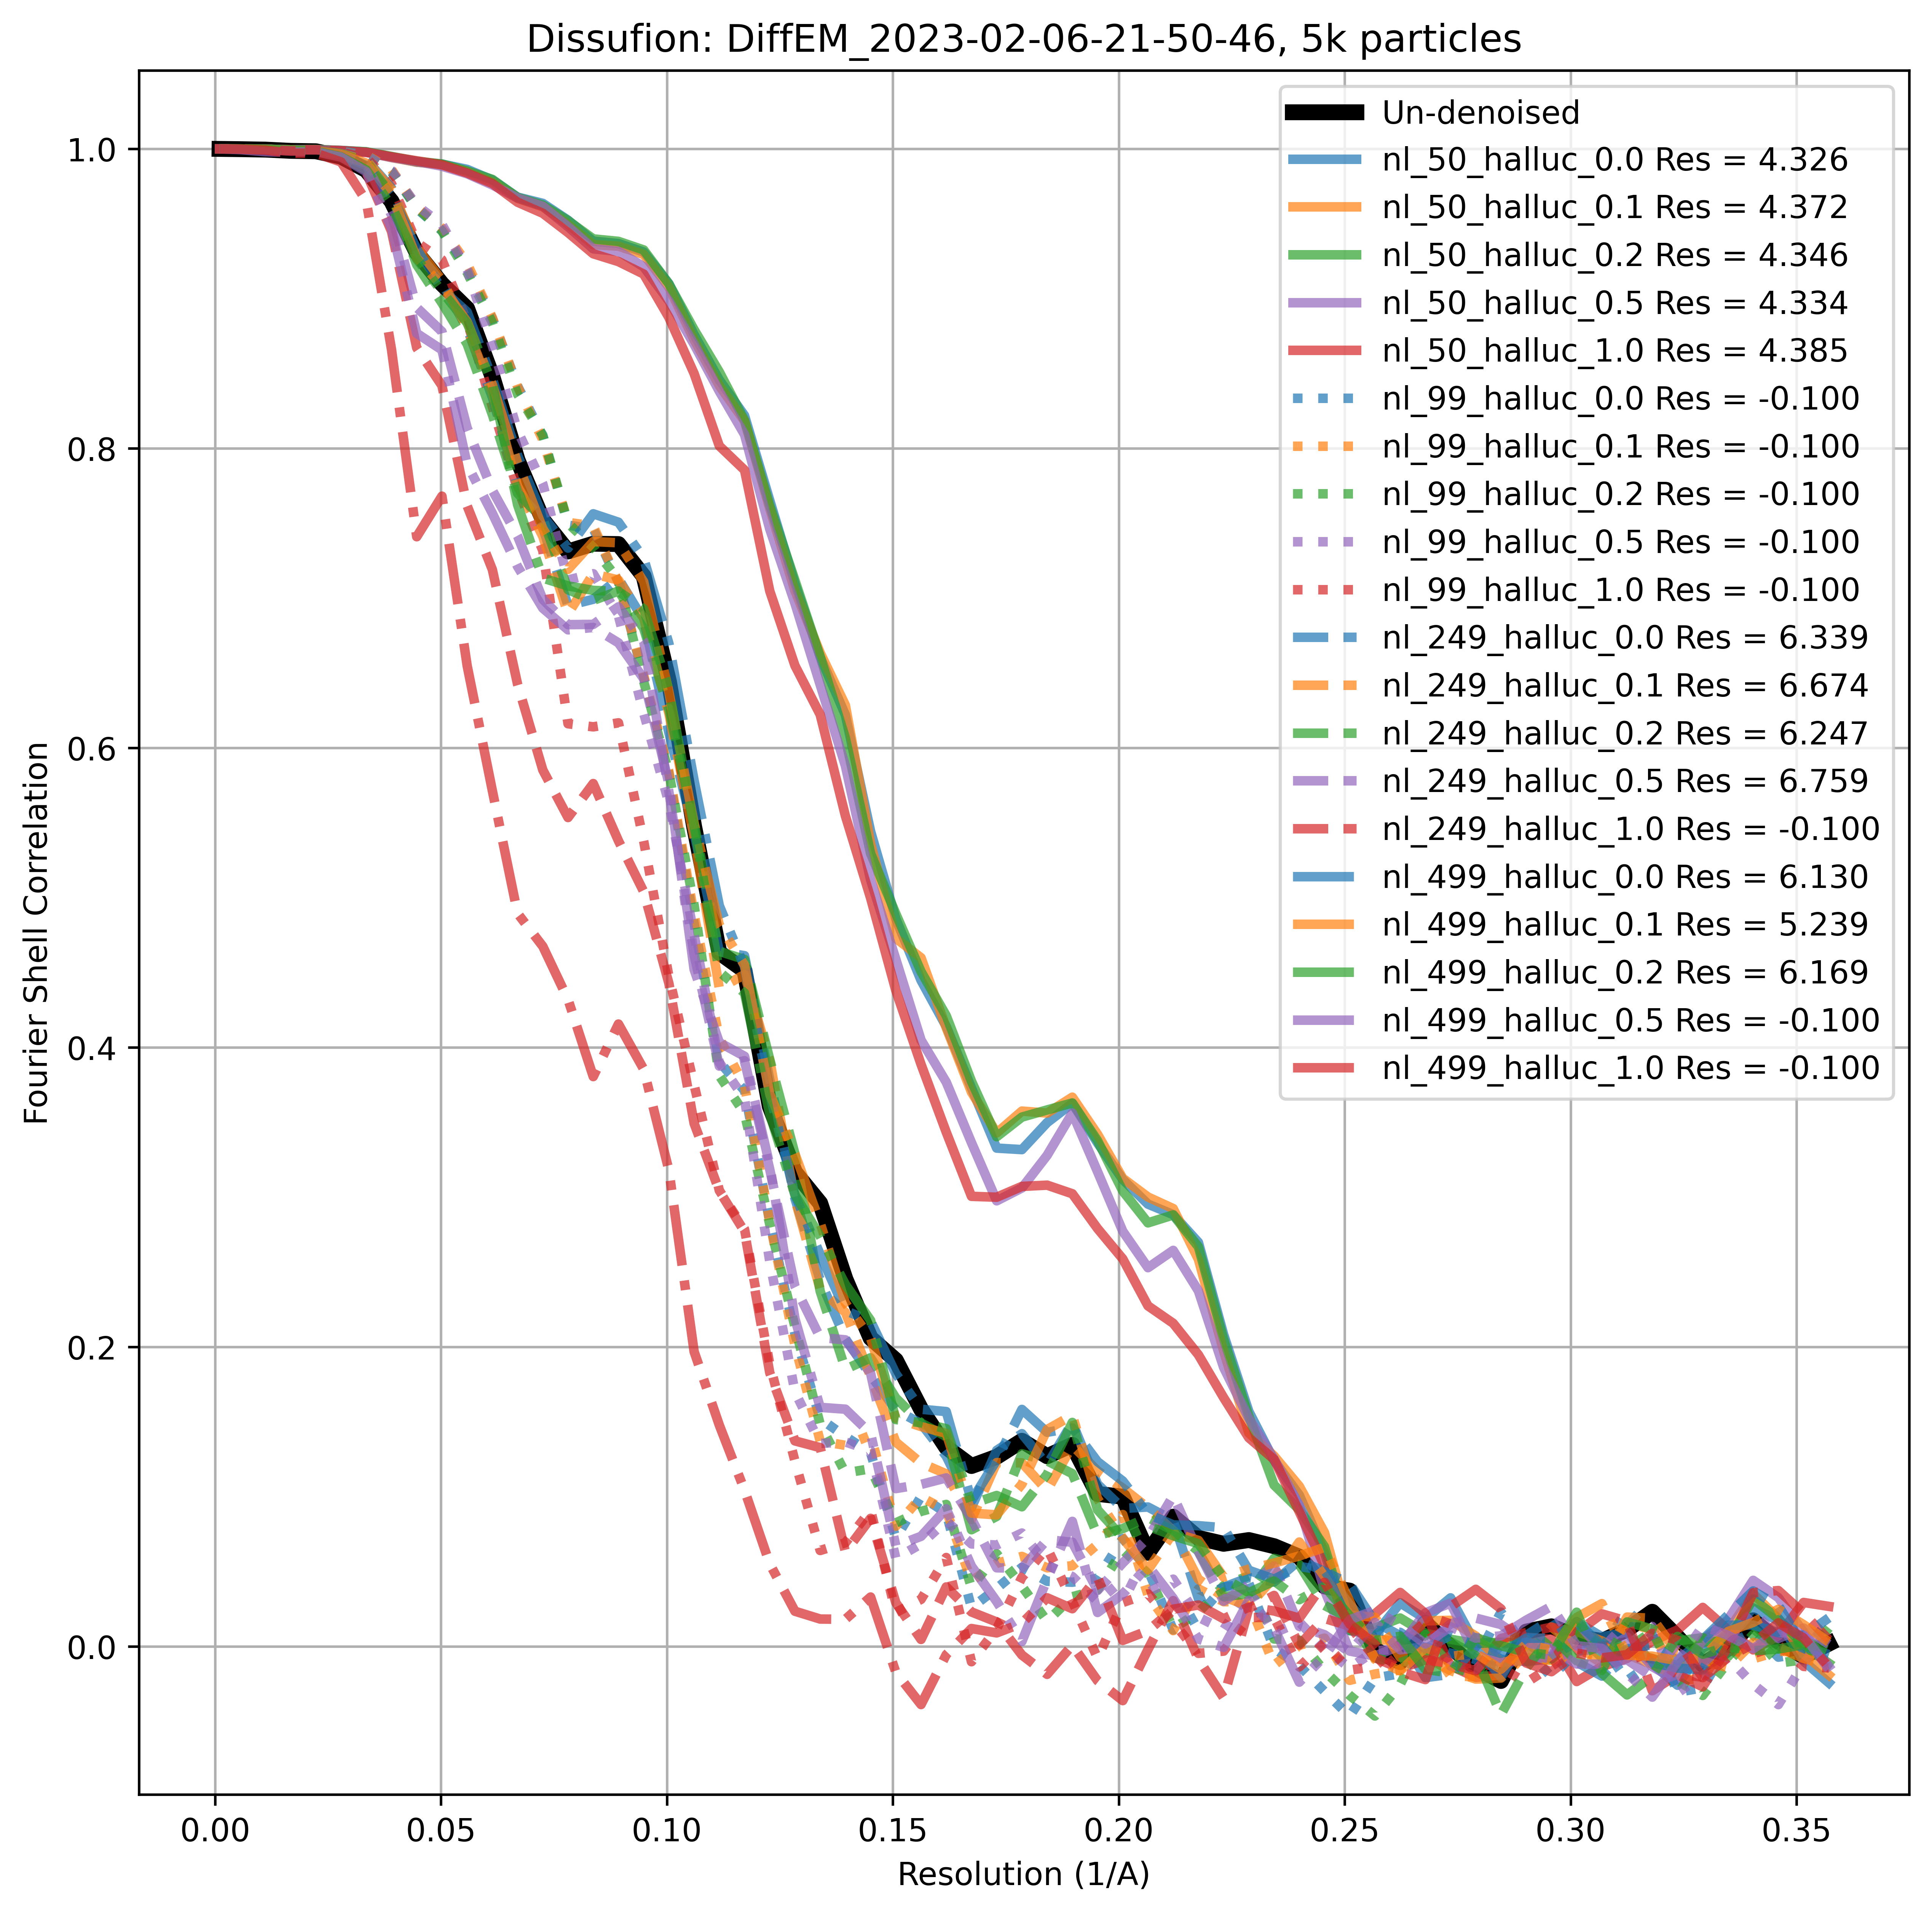

In [164]:
model_name = 'DiffEM_2023-02-06-21-50-46'
particle = '5k'
plot_fscs(rlt1[particle]['fsc'], rlt2[model_name][particle], model_name=model_name, particle=particle)